In [1]:
%matplotlib inline
%load_ext rpy2.ipython


import datetime as dt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import statsmodels.api as sm
from pykalman import KalmanFilter
import numpy.ma as ma

pd.set_option('max_rows', 10)
# pd.set_option('max_rows', 1000)

In [2]:
%%R

library(MARSS)

# Data

## Regressors

In [3]:
data = pd.read_excel('Data.xlsx',None,dayFirst=True)

data = list(data.values())

dat=pd.DataFrame()

# del data[6]


for df in data:
    df.set_index("Date", inplace=True)
#     df.drop_duplicates(inplace=True)

In [4]:
data = pd.concat(data,axis=1)
data.sort_index(inplace=True)

### Transformations


In [5]:
data.columns

Index(['UnemploymentRate', 'Imports', 'EmploymentRate', 'RetailFoodSales',
       'GeneralBusinessConditions', 'Exports', 'DisposableIncome',
       'NewResidentialSales', 'ProducerPriceIndex', 'JoblessClaims',
       'ConsumerConfidence', 'ConsumerPriceIndex',
       'IndustrialProductionIndex'],
      dtype='object')

In [6]:
data["IndustrialProductionIndex"] = np.log(data["IndustrialProductionIndex"]) - np.log(data["IndustrialProductionIndex"].shift(1))
data["ConsumerConfidence"] = np.log(data["ConsumerConfidence"]) - np.log(data["ConsumerConfidence"].shift(1))
data["Imports"] = np.log(data["Imports"]) - np.log(data["Imports"].shift(1))
data["Exports"] = np.log(data["Exports"]) - np.log(data["Exports"].shift(1))
data["ProducerPriceIndex"] = np.log(data["ProducerPriceIndex"]) - np.log(data["ProducerPriceIndex"].shift(1))
data["JoblessClaims"] = np.log(data["JoblessClaims"]) - np.log(data["JoblessClaims"].shift(1))
data["RetailFoodSales"] = np.log(data["RetailFoodSales"]) - np.log(data["RetailFoodSales"].shift(1))
data["NewResidentialSales"] = np.log(data["NewResidentialSales"]) - np.log(data["NewResidentialSales"].shift(1))
data["UnemploymentRate"] = data["UnemploymentRate"] - data["UnemploymentRate"].shift(1)
data["EmploymentRate"] = data["EmploymentRate"] - data["EmploymentRate"].shift(1)
data["DisposableIncome"] = np.log(data["DisposableIncome"]) - np.log(data["DisposableIncome"].shift(1))
data["GeneralBusinessConditions"] = np.log(data["GeneralBusinessConditions"]) - np.log(data["GeneralBusinessConditions"].shift(1))
data["ConsumerPriceIndex"] = data["ConsumerPriceIndex"]

# data["ConsumerPriceIndex"].loc[dt.datetime(2009,1,1):].plot()

### Stationarity

In [7]:
for series in data.columns:
    d = data[series]    
    pv = sm.tsa.stattools.adfuller(d[d.notnull()])[1]
    if pv > 0.05:
        print(series + " 's p-value is: " + str(pv))

EmploymentRate 's p-value is: 0.345649514846
RetailFoodSales 's p-value is: 0.627133470279
NewResidentialSales 's p-value is: 0.988370553646
JoblessClaims 's p-value is: 0.24770534847


## Response Variable

In [8]:
gdp = pd.read_excel('GDP.xlsx',dayFirst=True)
gdp.set_index("Date", inplace=True)
gdp["GDP"] = np.log(gdp["GDP"]) - np.log(gdp["GDP"].shift(1))

# Balanced Panel

In [9]:
balancedIndex = ~data.isnull().any(axis=1)
data[balancedIndex]

UnemploymentRate   Imports  EmploymentRate  RetailFoodSales  \
Date                                                                      
2010-01-31            -0.001 -0.067987          -0.004        -0.236325   
2010-02-28             0.004  0.027679          -0.002        -0.048187   
2010-03-31             0.009  0.242947          -0.002         0.231714   
2010-04-30             0.002 -0.081357           0.003        -0.160867   
2010-05-31             0.000  0.026540          -0.001         0.055060   
...                      ...       ...             ...              ...   
2015-09-30             0.003  0.031345           0.000        -0.032144   
2015-10-31             0.001  0.062352          -0.003         0.050344   
2015-11-30            -0.002 -0.108404           0.003        -0.008048   
2015-12-31            -0.002 -0.178960           0.006         0.180637   
2016-01-31             0.001 -0.021115          -0.007        -0.260511   

            GeneralBusinessConditions   Exports  DisposableIncome  \
Date                                                                
2010-01-31                   0.020834 -0.246317          0.008873   
2010-02-28                   0.051153  0.075958          0.004470   
2010-03-31                   0.029827  0.254201         -0.018580   
2010-04-30                   0.002590 -0.036670          0.007699   
2010-05-31                  -0.007789  0.154966          0.004203   
...                               ...       ...               ...   
2015-09-30                  -0.027365  0.041913          0.004298   
2015-10-31                   0.032261 -0.006162          0.022878   
2015-11-30                  -0.090681 -0.150516          0.048696   
2015-12-31                  -0.045120  0.195251          0.077145   
2016-01-31                   0.023498 -0.400408         -0.013376   

            NewResidentialSales  ProducerPriceIndex  JoblessClaims  \
Date                                                                 
2010-01-31             0.013766            0.014889      -0.188285   
2010-02-28             0.035409            0.012143       0.069042   
2010-03-31             0.046870           -0.001559       0.165317   
2010-04-30             0.030556            0.003989      -0.136788   
2010-05-31             0.036153            0.004650       0.029296   
...                         ...                 ...            ...   
2015-09-30             0.010601            0.029448      -0.038988   
2015-10-31             0.006654            0.017563      -0.011137   
2015-11-30             0.004195           -0.004184      -0.071361   
2015-12-31             0.004549           -0.003574       0.144448   
2016-01-31            -0.003513            0.006780      -0.148253   

            ConsumerConfidence  ConsumerPriceIndex  IndustrialProductionIndex  
Date                                                                           
2010-01-31            0.016840                0.75                  -0.069069  
2010-02-28           -0.067030                0.78                  -0.001136  
2010-03-31            0.035091                0.52                   0.180426  
2010-04-30            0.003038                0.57                  -0.083052  
2010-05-31            0.023977                0.43                   0.039419  
...                        ...                 ...                        ...  
2015-09-30           -0.064633                0.54                   0.001036  
2015-10-31            0.040154                0.82                   0.036589  
2015-11-30            0.000000                1.01                  -0.071348  
2015-12-31           -0.022108                0.96                  -0.147563  
2016-01-31            0.042311                1.27                  -0.052274  

[73 rows x 13 columns]

In [10]:
n_components=1
pca = PCA(n_components=n_components)
components = pca.fit_transform(data[balancedIndex])
components = pd.DataFrame(components)
components.set_index(data[balancedIndex].index, inplace=True)

print(pca.explained_variance_ratio_) 

[ 0.6241585]


## MARSS R-Package

In [11]:
balancedPanel = data[balancedIndex].transpose().as_matrix()
initial = components.transpose().as_matrix()

zs = []
for i in range(0,26):
    zs.append('z'+str(i))

In [12]:
%%R -i balancedPanel,zs,initial -o states

# class(meas)

Z="unconstrained"
# B="diagonal and unequal"
# B="identity"
B="unconstrained"
# x0=matrix(c("pi1"),1,1)
# x0=matrix(c("pi1","pi2"),2,1)

Z=matrix(list("z1","z2","z3","z4","z5","z6","z7","z8","z9","z10","z11","z12","z13"),13,1)
# Z=matrix(zs,13,2)

x0="zero"
x0=initial

model.gen=list(Z=Z,B=B,A="zero",x0="zero",U="zero")
# model.gen=list(Z=Z,B=B,x0=x0,A="zero")
kemfit = MARSS(balancedPanel, model=model.gen,control=list(conv.test.slope.tol=0.00001,abstol=0.00001))
states = kemfit$states
# print(kemfit, what="model")
# print(kemfit, what="start")
# print(kemfit, what="states")
# print(kemfit, what="ytT")
# print(kemfit, what="states.se")
# print(kemfit, what="kfs")
# print(kemfit$par$Z)

Success! abstol and log-log tests passed at 20 iterations.

MARSS fit is
Estimation method: kem 
Convergence test: conv.test.slope.tol = 1e-05, abstol = 1e-05
Estimation converged in 20 iterations. 
Log-likelihood: 1108.346 
AIC: -2184.692   AICc: -2184.108   
 
       Estimate
Z.z1    0.00587
Z.z2   -0.06828
Z.z3   -0.00468
Z.z4   -0.09483
Z.z5   -0.03495
Z.z6   -0.08973
Z.z7    0.05846
Z.z8    0.12630
Z.z9    0.03235
Z.z10  -0.03575
Z.z11  -0.06008
Z.z12   4.79193
Z.z13  -0.09699
R.diag  0.00464
B.B     0.95831
Q.Q     0.00229

Standard errors have not been calculated. 
Use MARSSparamCIs to compute CIs and bias estimates.



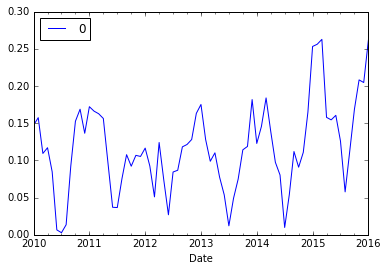

In [13]:
factor = pd.DataFrame(states).transpose().set_index(data[balancedIndex].index)
factor.plot()

/Users/mac/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


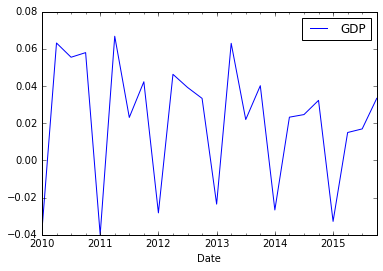

In [14]:
gdp[balancedIndex].plot()

# OLS - Nowcast

In [15]:
factor = factor.rolling(window=3).sum()
olsSample = gdp.join(factor, how="inner")
gdpComp = olsSample[0]

In [16]:
# X = sm.add_constant(gdpComp)
X = gdpComp
model = sm.OLS(olsSample["GDP"],X)
results = model.fit()
results.params
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     2.799
Date:                Sun, 04 Dec 2016   Prob (F-statistic):              0.108
Time:                        23:42:24   Log-Likelihood:                 44.699
No. Observations:                  24   AIC:                            -87.40
Df Residuals:                      23   BIC:                            -86.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0348      0.021      1.673      0.1

The model is not a good fit. We believe that could be due to the lack of specification of initial value for the parameters. Thus we will try do find initial value for the parameters running a VAR on PCA components, as in Banbura et al. 2013

# PCA to retrieve factors from balanced panel

In [17]:
n_components=5
pca = PCA(n_components=n_components)
components = pca.fit_transform(data[balancedIndex])
components = pd.DataFrame(components)
components.set_index(data[balancedIndex].index, inplace=True)

print(pca.explained_variance_ratio_) 

[ 0.6241585   0.22421535  0.08139473  0.02986808  0.01642318]


In [18]:
sum(pca.explained_variance_ratio_)

0.97605984190422534

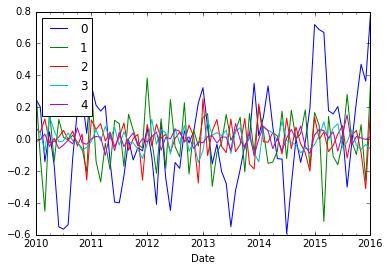

In [19]:
pd.DataFrame(components).plot()

# Initial Parameters Estimation 
## VAR - for B-Matrix Estimation

In [20]:
varModel = sm.tsa.VAR(components)
results = varModel.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, Dec, 2016
Time:                     23:42:25
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -22.1591
Nobs:                     72.0000    HQIC:                  -22.7301
Log likelihood:           351.061    FPE:                9.23150e-11
AIC:                     -23.1078    Det(Omega_mle):     6.18674e-11
--------------------------------------------------------------------
Results for equation 0
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.003938         0.023643            0.167           0.868
L1.0          0.700590         0.082908            8.450           0.000
L1.1         -0.088209         0.134782           -0.654           0.515
L1.2         -0.423460 

In [21]:
initialB = pd.DataFrame(results.coefs[0])

## OLS For Z-Matrix estimation

In [22]:
results = sm.OLS(data[balancedIndex]['ConsumerConfidence'], components).fit()
results.params

0   -0.026572
1    0.000310
2    0.005678
3   -0.045861
4    0.077941
dtype: float64

In [23]:
dfList = []
for col in data[balancedIndex].columns:
    results = sm.OLS(data[balancedIndex][col], components).fit()
    dfList.append(results.params)

initialZ = pd.concat(dfList,axis=1).transpose()
initialZ

0         1         2         3         4
0   0.003501 -0.003605  0.009224  0.019934  0.017436
1  -0.068671 -0.311816  0.726352 -0.202369 -0.549040
2  -0.004183 -0.005169 -0.018087 -0.003965 -0.014770
3  -0.115118 -0.479418 -0.431064 -0.521580  0.068239
4  -0.001035  0.006633  0.139386  0.143790  0.191768
..       ...       ...       ...       ...       ...
8   0.000789  0.003003  0.004543  0.001386  0.018411
9  -0.047185 -0.296605  0.024675 -0.499237  0.160976
10 -0.026572  0.000310  0.005678 -0.045861  0.077941
11  0.979236 -0.189912  0.025137 -0.025244  0.038386
12 -0.091358 -0.210319  0.473270  0.061192  0.773552

[13 rows x 5 columns]

# Re-Estimation of Factor Model by EM Algo

In [24]:
initialB.shape

(5, 5)

In [25]:
initialZ = np.reshape(initialZ.stack().as_matrix(),(65,1))
initialB = np.reshape(initialB.stack().as_matrix(),(25,1))
print(initialZ.shape)
print(initialB.shape)

(65, 1)
(25, 1)


In [26]:
numberOfFactors = 5
zs = []
for i in range(0,13*numberOfFactors):
    zs.append('z'+str(i))
    


In [51]:
%%R -i balancedPanel,zs,initialB,initialZ,numberOfFactors -o states

# class(meas)
print(dim(initialZ))
Z="unconstrained"
# B="diagonal and unequal"
# B="identity"
B="unconstrained"
# x0=matrix(c("pi1"),1,1)
# x0=matrix(c("pi1","pi2"),2,1)

# Z=matrix(list("z1","z2","z3","z4","z5","z6","z7","z8","z9","z10","z11","z12","z13"),13,1)
Z=matrix(zs,13,numberOfFactors)
# print(Z)
# print(numberOfFactors)
inits = list(Z=initialZ, B=initialB)

x0="zero"
x0=initial

model.gen=list(Z=Z,B=B,A="zero",x0="zero",U="zero")
# model.gen=list(Z=Z,B=B,x0=x0,A="zero")
# kemfit = MARSS(balancedPanel, model=model.gen)
# kemfit = MARSS(balancedPanel, model=model.gen,control=list(conv.test.slope.tol=0.00001,abstol=0.00001))
# kemfit = MARSS(balancedPanel, model=model.gen,control=list(conv.test.slope.tol=0.00001,abstol=0.00001),inits=inits)
kemfit = MARSS(balancedPanel, model=model.gen,inits=inits)
states = kemfit$states
# print(kemfit, what="model")
# print(kemfit, what="start")
# print(kemfit, what="states")
# print(kemfit, what="ytT")
# print(kemfit, what="states.se")
# print(kemfit, what="kfs")
print(dim(kemfit$par$Z))

[1] 65  1
Success! abstol and log-log tests passed at 203 iterations.
Alert: conv.test.slope.tol is 0.5.
Test with smaller values (<0.1) to ensure convergence.

MARSS fit is
Estimation method: kem 
Convergence test: conv.test.slope.tol = 0.5, abstol = 0.001
Estimation converged in 203 iterations. 
Log-likelihood: 1748.79 
AIC: -3305.58   AICc: -3283.721   
 
           Estimate
Z.z0       9.15e-03
Z.z1      -5.23e-02
Z.z2      -7.59e-03
Z.z3      -3.87e-01
Z.z4       7.85e-02
Z.z5      -6.90e-02
Z.z6      -3.03e-02
Z.z7       6.79e-03
Z.z8       5.55e-03
Z.z9      -2.27e-01
Z.z10     -2.32e-02
Z.z11      5.01e-01
Z.z12      5.65e-02
Z.z13     -5.95e-03
Z.z14     -2.29e-01
Z.z15      2.50e-03
Z.z16     -1.84e-01
Z.z17     -8.10e-02
Z.z18     -3.17e-01
Z.z19      6.01e-02
Z.z20      4.81e-03
Z.z21      1.40e-03
Z.z22     -1.88e-01
Z.z23     -3.77e-02
Z.z24      1.14e+00
Z.z25     -4.51e-01
Z.z26     -2.95e-03
Z.z27     -3.34e-01
Z.z28      5.23e-03
Z.z29      7.93e-02
Z.z30     -3.68e-02

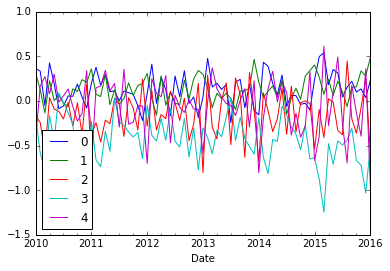

In [52]:
factor = pd.DataFrame(states).transpose().set_index(data[balancedIndex].index)
factor.plot()

/Users/mac/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


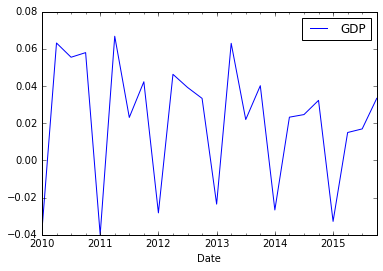

In [53]:
gdp[balancedIndex].plot()

# OLS - Nowcast

In [54]:
# factor = factor.rolling(window=3).sum()
olsSample = gdp.join(factor, how="inner")
gdpComp = olsSample[[0,1,2,3,4]]

In [55]:
gdpComp.head()

0         1         2         3         4
Date                                                        
2010-03-31 -0.050830 -0.134583 -0.580993 -0.772219  0.270543
2010-06-30 -0.087623  0.066038 -0.117453  0.089949 -0.015276
2010-09-30  0.050760  0.134164 -0.280186 -0.259827 -0.061916
2010-12-31 -0.080340  0.205858  0.184207 -0.735241  0.338286
2011-03-31  0.176064  0.048689 -0.460524 -0.736754  0.168040

In [56]:
# X = sm.add_constant(gdpComp)
X = gdpComp
model = sm.OLS(olsSample["GDP"],X)
results = model.fit()
results.params
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     6.400
Date:                Sun, 04 Dec 2016   Prob (F-statistic):            0.00121
Time:                        23:47:46   Log-Likelihood:                 55.170
No. Observations:                  24   AIC:                            -100.3
Df Residuals:                      19   BIC:                            -94.45
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0140      0.031     -0.452      0.6

Next Steps:

* Compare PCA Factors to Smoothed Factors
* Compare Predicted GDP to actual